# Notas para modificación

* Remover el stemming para ver si mejora la calificación de la polaridad
* Cómo modificar elementos de polaridad que por contexto se entienden pero que problamente no lo sabe la herramienta
* Estos comentarios son los anotados por la escuela, el sentimiento puede ser diferente a los escritos por el mismo padre de familia, ver si hay diferencia
* Cargar los scores en un nuevo dataframe

## Librerías

La librería principal es NLPT - Natural Language Processing Toolkit soportado para el lenguaje inglés. 

In [1]:
import nltk

El SSL debe estar deshabilitado de otra manera un error 'certificate verify failed' seguirá apareciendo. Debe de abrir la ventana con las librerías del nltk y descargar las requeridas. En este caso se necesita el vader_lexicon que es obligatorio para usar SentimentIntensityAnalyzer. Aunque ya se descargaron por primera vez, como no está deshabilidado saldrá el pop up cada vez.

In [ ]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Preprocesamiento

Para esta primera prueba, la data ha sido "limpiada" en sintaxis y errores gramaticales. De acuerdo con MS Office el editor indicaba una puntuación de 75%, después de las correcciones la puntuación es de 97%. La desventaja del NLPT es que no soporta el español, por lo que básicamente hay dos opciones:

1. Traducir el texto a inglés, sin embargo las ideas pueden cambiar durante este proceso entre otros problemas.
2. Usar "parches" con el cual se use el NLPT pero adapatado en el español sin embargo el soporte puede no estar adaptado completamente entre otros problemas en cuanto al código.

Tanto los errores ortográficos/sintaxis como la traducción pueden incluirse dentro del código a través de un API, como primera aproximación se alimentará con la data limpia de errores y traducida. Queda pendiente probar los parches disponibles para el español y adaptarlo al código además de automatizar la limpieza y traducción.

Aún con la data limpia, se deben realizar ciertos pasos antes para realizar el análisis:

* Tokenización, es decir, dividir el texto en frases
* Stemming, que es un método para reducir una palabra a su raíz o a un stem (ex. consult, consulting, consultant, etc)
* Lemmanization, hace el trabajo de relacionar las palabras con significados aproximados o que estén relacionadas (ex. good, better, etc)

Ambos ayudan a asignar varias palabras a una raíz común. De esa manera, estas palabras se tratan de manera similar y el modelo aprende que se pueden usar en contextos similares.

In [13]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer

nltk.download('stopwords')
# en este punto se entiende que básicamente todas las palabras están en un archivo
# por lo que cada librería no sólo debe ser importada sino que se debe descargar
# ese archivo que contiene las palabras de la librería
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def preprocess(raw_text):
    
    # regex para identificar únicamente letras (en caso de que haya símbolos)
    # habría que ver si ciertos símbolos son importantes como por ejemplo ($)
    # en caso de que se hable de montos monetarios
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convierte en minúsculas and separa las palabras, ex. 'hello world' -> ['hello', 'world']
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = PorterStemmer() # se puede agregar un stemmer, lemmanizer(? en particular
    
    # remover los stopwords
    stopWords = set(stopwords.words('english'))
    # hay stopwords disponibles en español o bien hacer un txt con los stopwords que quiera
    # REF: https://pythonspot.com/nltk-stop-words/
    for word in words:
        if word not in stopWords:
            cleaned_words.append(word)
    
    # stemm o lemmatise
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)   # es exactamente lo mismo para lemmatise pero con 'lemmatize' en vez de stem
        stemmed_words.append(word)
    
    # regresa la lista de strings
    return " ".join(stemmed_words)

In [15]:
test_sentence = "this is a sentence to demonstrate how the preprocessing function works...!"

preprocess(test_sentence)

'sentenc demonstr preprocess function work'

## Load Data

In [ ]:
# import pandas as pd
# url ='https://github.com/msof07/rcsa_lab/blob/28989d50f3879835de97b0efe4bac81e9146fb71/comments_clean.xlsx'
# comments_df = pd.read_excel(url)

# github's raw link not working for private repositories i have to check how to concede permissions later

In [25]:
from google.colab import drive

drive.mount("/content/gdrive")

comments_df = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Datasets/comments_clean.xlsx')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
comments_df.head()

,Comentarios,Comentarios traducidos
0,La familia notificó que se van al Kennedy por...,The family notified that they are going to the...
1,La familia hace traslado porque solo quiere cl...,The family relocates because they only want on...
2,Sonia Villarreal avisó que ya había hecho su p...,Sonia Villarreal announced that she had alread...
3,El motivo real de la baja que tomará clases en...,The real reason for the withdrawal that he wil...
4,La familia quiere educación Montessori,The family wants Montessori education


## Palabras comunes con un WordCloud

#### Key WordCloud antes del procesamiento

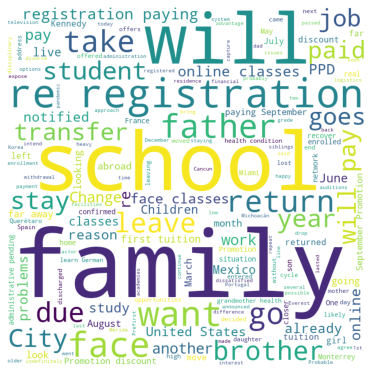

In [28]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
# usar %matplotlib inline para Jupyter notebook

all_words = '' 

for arg in comments_df['Comentarios traducidos']: 

    tokens = arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# WordCloud image plot               
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### Key WordCloud después del procesamiento

In [35]:
comments_df['prep'] = comments_df['Comentarios traducidos'].apply(preprocess)
comments_df.head()

,Comentarios,Comentarios traducidos,prep
0,La familia notificó que se van al Kennedy por...,The family notified that they are going to the...,famili notifi go kennedi want ib
1,La familia hace traslado porque solo quiere cl...,The family relocates because they only want on...,famili reloc want onlin class due pandem
2,Sonia Villarreal avisó que ya había hecho su p...,Sonia Villarreal announced that she had alread...,sonia villarr announc alreadi done process sin...
3,El motivo real de la baja que tomará clases en...,The real reason for the withdrawal that he wil...,real reason withdraw take class onlin sinc wan...
4,La familia quiere educación Montessori,The family wants Montessori education,famili want montessori educ


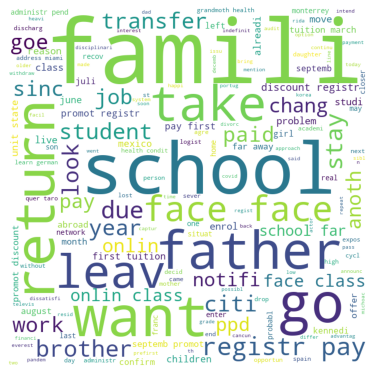

In [38]:
all_words = '' 

for arg in comments_df['prep']: 

    tokens = arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# WordCloud image plot               
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Está saltando el valor de 'face' y 'face-to-face' por la traducción de "presencial", lo cual se identifica en los n-grams:

```
('want', 'face-to-face') 4
('face-to-face', 'classes.') 2
```

In [36]:
from collections import Counter
Counter(" ".join(comments_df['prep']).split()).most_common(10)

[('famili', 66),
 ('school', 49),
 ('face', 32),
 ('registr', 32),
 ('pay', 32),
 ('class', 26),
 ('want', 24),
 ('go', 23),
 ('return', 23),
 ('father', 20)]

In [ ]:
from nltk.util import ngrams
n_gram = 2
n_gram_dic = dict(Counter(ngrams(all_words.split(), n_gram)))

for i in n_gram_dic:
    if n_gram_dic[i] >= 2:
        print(i, n_gram_dic[i])

## Análisis de polaridad

* neg (negativa)
* neu (neutral)
* pos (positiva)

compound: valor entre -1 y 1 indica si la frase es positiva o negativa. Valores próximos a -1 indican que es muy negativa, próximos a cero indicarían que es neutra y próximos a 1 sería muy positiva.

In [40]:
from nltk. sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

In [42]:
# sentiment indicator
sind = SentimentIntensityAnalyzer()

In [44]:
for comments in comments_df['prep']:
  print(comments)
  scores = sind.polarity_scores(comments)
  for key in scores:
    print(key, ":", scores [key])
    print()

# Acomodar en un df

famili notifi go kennedi want ib
neg : 0.0

neu : 0.794

pos : 0.206

compound : 0.0772

famili reloc want onlin class due pandem
neg : 0.0

neu : 0.822

pos : 0.178

compound : 0.0772

sonia villarr announc alreadi done process sinc last year leav
neg : 0.0

neu : 1.0

pos : 0.0

compound : 0.0

real reason withdraw take class onlin sinc want face face class
neg : 0.0

neu : 0.885

pos : 0.115

compound : 0.0772

famili want montessori educ
neg : 0.0

neu : 0.698

pos : 0.302

compound : 0.0772

chang resid due work father
neg : 0.0

neu : 1.0

pos : 0.0

compound : 0.0

famili want person go transfer go school assur whole year onlin
neg : 0.0

neu : 0.885

pos : 0.115

compound : 0.0772

goe abroad leav paid registr cycl
neg : 0.0

neu : 1.0

pos : 0.0

compound : 0.0

student sever eat problem anorexia temporari sick leav case manag recov
neg : 0.4

neu : 0.6

pos : 0.0

compound : -0.7184

leav take class onlin sinc school offer face face
neg : 0.0

neu : 1.0

pos : 0.0

compound :

## Topic Modeling

En proceso...